## 1. Exploratory Data Analysis

This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features to work with

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

df_wine.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand.  When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

In [2]:
# define plotting function

def myplotGrid(X,y):
#Need to input a numpy array extracted features, and numpy array of the target
#Creating a new Dataframe with target column for target data 
#Passing the new dataframe into sns.pairplot to produce the graphs 
    df_X = pd.DataFrame(X)
    df_X['Target']= y
    df_X = df_X.rename(columns = dict(zip([i for i in range(len(selected_features))],[i for i in selected_features])))
    return sns.pairplot(df_X, diag_kind='kde', hue = 'Target', palette='deep')



In [3]:
def myplotGrid(X,y):
    
    """ 
    Takes in two arrays and uses sns.pairplot to plot pairwise relationships. 

    This function will create a dataframe from `X` and `y`.
    Then create a grid of Axes such that each numeric variable in ``X`` 
    will by shared across the y-axes across a single row and
    the x-axes across a single column. The diagonal plots are treated 
    differently: a univariate KDE plot is drawn. 

    Parameters
    ----------
    X : numpy.ndarray
        Array of the selected features 
    y : numpy.ndarray
        Array of the target classes
    Returns
    -------
    pairplot_matrix : seaborn.axisgrid.PairGrid
        Matrix of pairwise relationships between features 
        
    """ 
    df_X = pd.DataFrame(X)
    df_X['Target']= y
    df_X = df_X.rename(columns = {0:'alcohol', 1:'flavanoids', 2:'color_intensity', 3:'ash'})
    pairplot_matrix = sns.pairplot(df_X, diag_kind='kde', hue = 'Target', palette='deep')
    
    return pairplot_matrix 




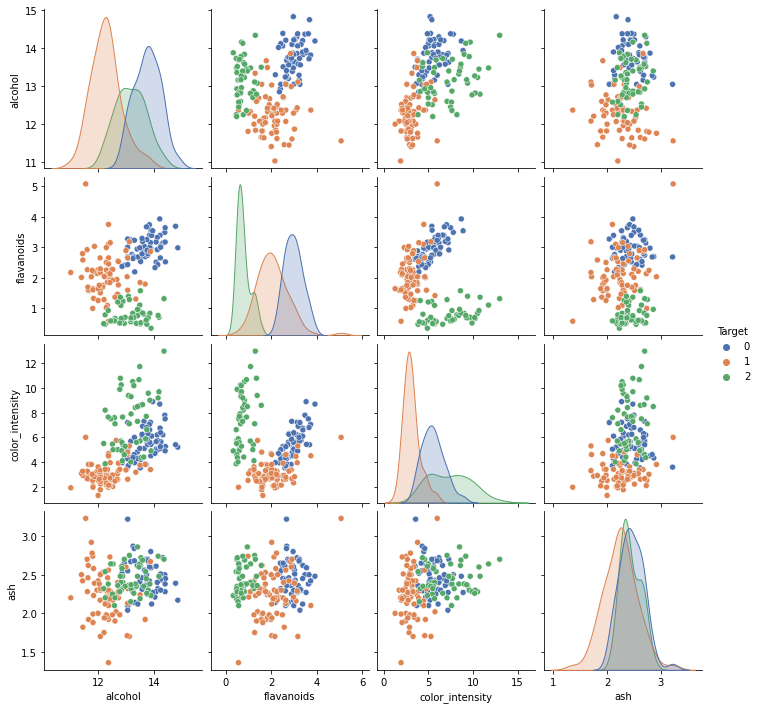

In [4]:
# run the plotting function
import seaborn as sns

myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging.

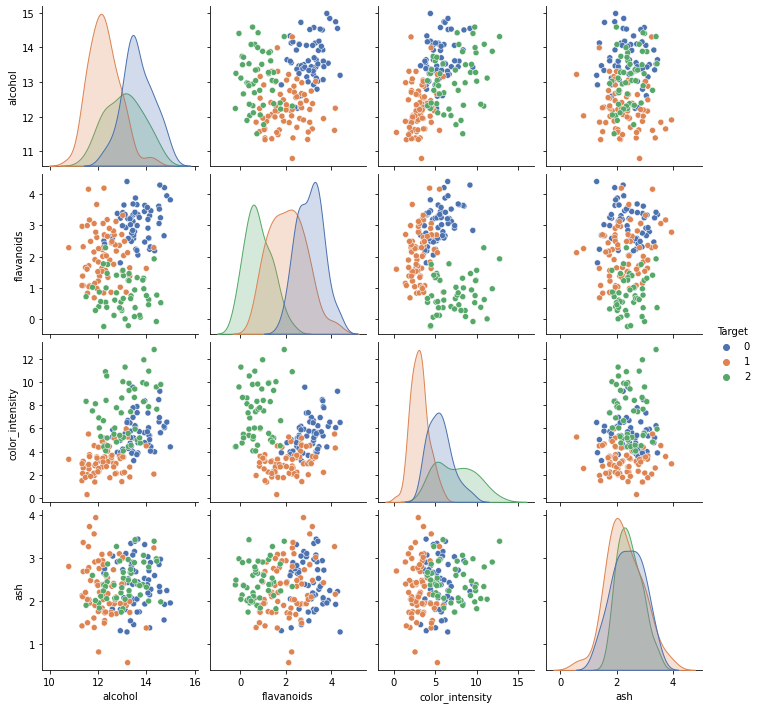

In [5]:
# noise code 
mySeed = 12345 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)

myplotGrid(XN,y)

### 1.3 What are the best features?


Feature selection is utilised prior to training a machine learning algorithm to reduce the number of input variables to the ones that are considered the most useful to predict the target variable in this case the classes of wine. For classification, class separability can be a useful indicator of which features best distinguish between classes, ultimately increasing the accuracy of classification algorithms. 

When looking at the KDE plots and the distance between the histograms, alcohol flavonoids and colour intensity appear to have the least overlap between the curves and the centre of the histograms. Clearly Ash has large overlap between each class. 

Furthermore, by comparing the scatterplots of the remaining three variables, this can indicate which combination of features best discriminate the data into the three separate classes. The scatterplots indicate that alcohol and flavonoids better discriminate between the 3 classes, as the graphs show there is less overlap between the three classes.  I believe alcohol and flavanoids would be the best features to use for KNN. 


### 1.4 How does noise affect the data? 




Noise is considered any unwanted anomaly in the data, the addition of Gaussian noise can make a class more difficult to learn. Firstly, when comparing the KDE plots before and after adding noise, each class KDE curve appears to have a larger peak and width. A KDE plot estimates the distribution of a variable and the probability of an outcome falling within the range of values. As the KDE curves, have a larger width there is a higher probability that the outcome will fall between a large range of values. This can be seen in the scatterplots between the variables, with more data points from the distinct classes overlapping with other classes. Visually, the boundaries between classes is harder to distinguish. 


## 2. Implementing KNN 

I felt it would best to break the problem into various sub-problems, implemented as helper functions. 

For example, implementing separate function to:
- Split the data into testing and training
- Calculate the distances between two vectors. 
- Finds the k-neighbours of a point. 
- Predicts class labels for provided data.


#### Train Test Split Function 

In [6]:
def my_train_test_split(random_state, features, target, train_size=0.8):
    """
    Splits `attrs` and `labels` each into two random training and test sets.  
    
    Parameters
    ----------
    features : numpy.ndarray
        Array of selected features
    target : numpy.ndarray
        Array of the target classes
    train_size : float
        Proportion of training size 
    random_state : int
    
    Returns
    -------
    numpy.ndarray
    
    """
    np.random.seed(random_state)
    indices = np.random.permutation(np.arange(0,len(features),1)) #randomly shuffle indices 
    
    if len(features) != len(target):
        return False
    else:
        split = int(len(features) * train_size) # calculating the length of the training data
        
    return (features[indices[:split]], features[indices[split:]], target[indices[:split]], target[indices[split:]])



#### Calculating Distance

In [7]:
def distance_(a,b,distance):
    """
    Computes the distance between two vectors.
    
    Parameters
    ----------
    a : numpy.ndarray
    b : numpy.ndarray
    
    distance: {'euclidean','manhattan'}
        Distance metric to be calculated
    
    Returns
    -------
    Dis : numpy.ndarray
         Distance between `a`,`b`
    
    """
    if distance == 'euclidean':
        dis = np.sqrt(np.sum((a-b)**2, axis=1))
        return dis 

    elif distance == 'manhattan':
        dis = np.abs(a-b).sum(axis=1)
        return dis

#### Finds the k-neighbours of a point

In [8]:
def get_neighbors(X_train,X_test,y_train, distance,num_of_neighbours):
    """
    Finds the k-neighbours of a point.
    
    Computes the distance between each row of `X_test` and `X_train`, 
    and stores them as a list. Then appends the classes from `Y_train` 
    to the list of distances and sorts the list in descending order.
    Then, creates a new list appending the distances and classes 
    for the selected `num_of_neighbours`. 
    
    
    Parameters
    ----------
    X_train : numpy.ndarray
        Array of features to train on 
    X_test : numpy.ndarray
        Array of features to test on 
    y_train : numpy.ndarray
        Array of target classes to train on
    distance : {'euclidean','manhattan'}
        Distance metric to be calculated
    num_of_neighbours : int
        Number of neighbours 
    Returns
    -------
    list
        List of tuples (distance,class) for the selected `num_of_neighbours`.  
    
    """   
    
    # storing list of distances from each training point to each test point 
    lst = []
    for row in X_test:
        lst.append(distance_(row,X_train,distance))
    
    # adds the classes to the sublist of test points and sorts them based on the shortest distance 
    distance_target= []
    for i in range(len(lst)):
        distance_target.append(sorted(list(zip(lst[i],y_train))))
    
    # stores list of nearest neighbours for each test point in a new list 
    nearest_neighbours = []
    for i in range(len(distance_target)):
        nearest_neighbours.append(distance_target[i][:num_of_neighbours])
    
    return nearest_neighbours

#### Predicts class labels for provided data.

In [9]:
def predict(NN_list, neighbours, X_test):
    """
    Predicts class labels for provided data. 
    
    Unnests the list of tuples containing the classes and the distance 
    to the test point. 
    Then divides the list into sublists based on the `n_neighbours` 
    and the number of test points. E.g. if  `n_neighbours` = 5 and 
    number of testpoints = 36, will generate 35 lists with 10 values 
    in each (5 distances and 5 classes). 
    Then sorts the lists according to distance in descending order 
    and returns the predicted class for each test point. 
    
    
    Parameters
    ----------
    NN_list : list
        List of tuples (distance,target class) for the selected `num_of_neighbours`.
    n_neighbours : int
        Number of neighbours
    X_test : numpy.ndarray
        Array of features to test on 
    Returns
    -------
    y_pred : list
        List of predicted target classes
    
    """  
    
    #Unnesting the nearest neighbours list
    list_nn = [i for i in NN_list for i in i for i in i]
    num_test_points = len(X_test)
    y_pred = []
    
    
    # for every test point, splitting into a seperate list, for 5nn would have 10 values - 5 distances and 5 classes 
    # then find the most frequent class in temp, then append them to y_pred 
    for i in range(num_test_points):
        temp = (list_nn[int((i*(len(list_nn)/num_test_points))):int((2*i*neighbours) + (len(list_nn)/num_test_points))])
        y_pred.append(sorted(temp, key=temp.count)[-1])
        
    return y_pred

### Implementating KNN with Helper code

In [10]:
def my_KNN(X_train,X_test,y_train,dist_measure,nn,):
    """
    Calculates the distance between each test and training point, 
    finds the k-neighbours of the point, and then 
    predicts the class labels for the provided data.   
    
    
    Parameters
    ----------
    X_train : numpy.ndarray
        Array of features to train on
    X_test : numpy.ndarray 
        Array of features to test on 
    y_train : numpy.ndarray
        Array of target classes to train on
    dist_measure : {'euclidean','manhattan'}
        Distance metric to be calculated
    nn : int
        Number of neighbours 

    Returns
    -------
    y_pred
        List of predicted class labels for the data  
    
    """  
    
    list_nn = get_neighbors(X_train,X_test,y_train,dist_measure,nn)
    y_pred = predict(list_nn,nn, X_test)
    
    return y_pred

### Comparing my KNN to Scikit learn 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
X_train, X_test, y_train, y_test = my_train_test_split(2,X,y,train_size=0.8)

In [13]:
distances = ['euclidean', 'manhattan']
k_list = list(range(1,11))

In [14]:
my_scores = []

for k in k_list:
    for d in distances:
        
        my_y_pred = my_KNN(X_train, X_test,y_train,d,k)
        my_scores.append((d, k,accuracy_score(y_test, my_y_pred)))
    
my_scores

[('euclidean', 1, 0.9722222222222222),
 ('manhattan', 1, 0.9444444444444444),
 ('euclidean', 2, 0.9444444444444444),
 ('manhattan', 2, 0.9166666666666666),
 ('euclidean', 3, 0.9722222222222222),
 ('manhattan', 3, 0.9444444444444444),
 ('euclidean', 4, 0.9166666666666666),
 ('manhattan', 4, 0.9444444444444444),
 ('euclidean', 5, 0.9444444444444444),
 ('manhattan', 5, 0.9444444444444444),
 ('euclidean', 6, 0.9444444444444444),
 ('manhattan', 6, 0.9444444444444444),
 ('euclidean', 7, 0.9444444444444444),
 ('manhattan', 7, 0.9444444444444444),
 ('euclidean', 8, 0.9166666666666666),
 ('manhattan', 8, 0.9166666666666666),
 ('euclidean', 9, 0.9166666666666666),
 ('manhattan', 9, 0.9166666666666666),
 ('euclidean', 10, 0.8888888888888888),
 ('manhattan', 10, 0.9166666666666666)]

In [15]:
from sklearn.neighbors import KNeighborsClassifier

scores= []

for k in k_list:
    for d in distances: 
    
        knn = KNeighborsClassifier(n_neighbors=k, metric=d)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores.append((d, k,accuracy_score(y_test, y_pred)))
            
scores

[('euclidean', 1, 0.9722222222222222),
 ('manhattan', 1, 0.9444444444444444),
 ('euclidean', 2, 0.9444444444444444),
 ('manhattan', 2, 0.9444444444444444),
 ('euclidean', 3, 0.9722222222222222),
 ('manhattan', 3, 0.9444444444444444),
 ('euclidean', 4, 0.9444444444444444),
 ('manhattan', 4, 0.9444444444444444),
 ('euclidean', 5, 0.9444444444444444),
 ('manhattan', 5, 0.9444444444444444),
 ('euclidean', 6, 0.9444444444444444),
 ('manhattan', 6, 0.9444444444444444),
 ('euclidean', 7, 0.9444444444444444),
 ('manhattan', 7, 0.9444444444444444),
 ('euclidean', 8, 0.9166666666666666),
 ('manhattan', 8, 0.9166666666666666),
 ('euclidean', 9, 0.9166666666666666),
 ('manhattan', 9, 0.9166666666666666),
 ('euclidean', 10, 0.8888888888888888),
 ('manhattan', 10, 0.9166666666666666)]

## 3. Classifier evaluation

The classifier evaluation code includes the calculating confusion matrices, as well as common metrics like; accuracy, precision and recall.


### Classifier Evaluation Functions 

In [16]:
# confusion matrix, accuracy, precision, recall, etc. 

def conf_matrix(y_test, y_predict):
    """
    Creates a matrix of shape(number of classes, number of classes).
    
    This function, firstly creates an emtpy numpy.ndarray 
    of shape(number of classes, number of classes). 
    Then fills the matrix with the true and estimated target values. 
    
    Parameters
    ----------
    y_true: numpy.ndarray
        True target values
    y_predict: numpy.ndarray 
        Predicted target values 
    

    Returns
    -------
    d_m : numpy.ndarray 
        Confusion matrix of shape(number of classes, number of classes)
         
    """  
    
    dim = len(set(y_predict))
    d_m = np.zeros((dim,dim), dtype = np.int) #Adapted from : 2.2 ANSWERS KNN classification.html
    
    for i in range(len(y_predict)):
        d_m[y_test[i], y_predict[i]] += 1
    return d_m


def accuracy(matrix):
    """
    Computes the total accuracy score.  
    
    The accuracy score is calculated by doing the sum of the diagonal elements 
    divided by the sum of the values in the matrix. 
    
    Parameters
    ----------
    matrix : numpy.ndarray 
        Confusion matrix of shape(number of classes, number of classes)
    

    Returns
    -------
    accuracy : numpy.float64 
        Accuracy score 
         
    """  
    
    
    diag = []
    
    for i in range(len(matrix)):
        diag.append(matrix[i][i])
        accuracy = sum(diag)/np.sum(matrix)
        
    return accuracy



def precision(matrix):
    """
    Computes the precision for each class.   
    
    Precision score is computed by calculating 
    (true positives/true positives + false positives) and 
    represents the likelihood a prediction will be correct. 

    
    Parameters
    ----------
    matrix : numpy.ndarray 
        Confusion matrix of shape(number of classes, number of classes)
    

    Returns
    -------
    precision : list
        List of precision scores for each class        
         
    """ 
    
    precision = []
    for i in range(len(matrix)):
        precision.append(matrix[i][i]/np.sum(matrix[:,i]))
        
    return precision

def recall(matrix):
    """
    Computes the recall for each class.   
    
    Recall score is computed by calculating 
    (true positives/true positives + false negatives) 
    and represents the likelihood the classifier will predict 
    the true value. 

    
    Parameters
    ----------
    matrix : numpy.ndarray
        Confusion matrix of shape(number of classes, number of classes)
    

    Returns
    -------
    recall : list
        List of recall scores for each class  
             
    """ 
    
    recall = []
    for i in range(len(matrix)):
        recall.append(matrix[i][i]/ np.sum(matrix[i]))
        
    return recall

### Displaying Output of confusion matrix 

In [17]:
def plot_conf_matrix(c_m):
    """
    Plots a matrix from an array.
    
    
    Parameters
    ----------
    matrix : numpy.ndarray 
        Confusion matrix of shape(number of classes, number of classes)
    

    Returns
    -------
    matrix  : matplotlib.image.AxesImage  
        
                 
    """ 
    fig, ax = plt.subplots()
    matrix = ax.matshow(c_m, cmap='Blues')
    fig.colorbar(matrix)
    
    ax.set_xlabel('Predicted Classes', labelpad=10)
    ax.set_ylabel('Actual Classes',rotation=0, labelpad= 50)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    for (x,y),z in np.ndenumerate(c_m):   #Adapted from: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
        ax.text(y,x,z)
    
    return matrix

In [18]:
#Test data for classifier evaluation and confusion matrix
true = [0,1,2,2,1,1,2,2,1,2]
predicted = [0,1,1,2,2,1,2,2,0,2]

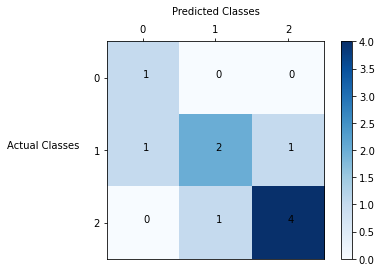

In [19]:
plot_conf_matrix(conf_matrix(true,predicted))

In [20]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

### Comparing my confusion matrix and metrics vs Sklearn matrix and metrics

In [21]:
# test evaluation code

print('Sklearn Confusion Matrix, Accuracy, Recall, Precision Scores: ', '\n')
print(confusion_matrix(true,predicted), '\n')
print('Accuracy :', accuracy_score(true,predicted))
print('Recall :',recall_score(true,predicted, average=None))
print('Precision : ', precision_score(true,predicted, average=None), '\n')

print('My Confusion Matrix, Accuracy, Recall, Precision Scores: ', '\n')
print(conf_matrix(true,predicted), '\n')
print('Accuracy :', accuracy(conf_matrix(true,predicted)))
print('Recall :',recall(conf_matrix(true,predicted)))
print('Precision : ', precision(conf_matrix(true,predicted)))


Sklearn Confusion Matrix, Accuracy, Recall, Precision Scores:  

[[1 0 0]
 [1 2 1]
 [0 1 4]] 

Accuracy : 0.7
Recall : [1.  0.5 0.8]
Precision :  [0.5        0.66666667 0.8       ] 

My Confusion Matrix, Accuracy, Recall, Precision Scores:  

[[1 0 0]
 [1 2 1]
 [0 1 4]] 

Accuracy : 0.7
Recall : [1.0, 0.5, 0.8]
Precision :  [0.5, 0.6666666666666666, 0.8]



## 4. Nested Cross-validation using your implementation of KNN

Performing 5-fold nested cross-validation allows the algorithm to evaluate the hyper parameters within an extra for loop of the KNN algorithm. 
    
In this case i chose to evaluate 2 distance measures and evaluates the neighbour parameter from 1 to 10. 

### Nested Cross Validation Code 

In [33]:
def my_nested_cross_val(features,target,folds,k_list, dis_measures, my_seed):
    """
    This function uses a series of training, test and validation splits 
    to perform nested cross validation.
    
    The outer loop splits the data into the 
    specified number of `folds`. The inner loop splits the training data into 
    training and validations sets and evaluates the `dis_measure` and `k_list`.
    Then trains and test the parameters with the best accuracy on 
    the outer folds of data. 
    
    Parameters
    ----------
    features : numpy.ndarray 
        Array of selected features
    target : numpy.ndarray
        Array of the target classes
    folds : int
        Number of folds
    k_list : list
        List of k values
    dis_measures : list
        List of distance metrics 
    my_seed : int
        Random seed used to replicate results
    Returns
    -------
    accuracies  : list  
        List of accuracies for each fold 
                 
    """ 
    
    #Creating random array of indices and then splitting into folds
    np.random.seed(my_seed)
    indices = np.random.permutation(np.arange(0,len(features),1))
    indices = np.array_split(indices, folds)
    
    accuracies = [] #list to store accuracies for each fold 
    outer_test_pred = [] #list to store true and predicted values for each fold
    
    for iFold in range(0,folds):  
    
        print('============ Fold %s ==============' % (iFold+1) , '\n')
    
        #Take one fold for testing 
        testFold = indices[iFold]
        
        remaining_folds = np.delete(range(0,folds), iFold)
        
        #Take the remaining folds as training
        outer_training_fold = np.hstack([indices[i] for i in remaining_folds])
    
    
        for j in range(0,1): #Inner loop begins, split every fold into validation and training
            
            #Take one fold from outer training data as validation
            inner_val = indices[remaining_folds[0]]
            
        
            #Take the rest of the data for training
            inner_train = np.hstack([indices[i] for i in remaining_folds[1:]])
            
        
            params_fold = [] #list used to store all validated parameters and their accuracies 
            Fold_accuracies_inner = []
            
            
            for k in k_list: # evaluate k and distance measures, on inner training and validation 
                
                for d in dis_measures:
                    
                    y_pred = my_KNN(features[inner_train], features[inner_val], target[inner_train], d, k)
                    
                    params_fold.append((d,k,'{:.3f}'.format(accuracy(conf_matrix(target[inner_val], y_pred)))))
                                        
            
            print('Accuracy Score for each Set of Parameters:','\n', *params_fold, sep = "\n", )
            # sort list so parameters with kighest accuracy are at the top
            params_fold.sort(key=lambda params_fold: params_fold[2], reverse=True)
            best_dist = params_fold[0][0]
            best_k = params_fold[0][1]
            print('\n') 
            print('Most Accurate Parameters: ', 'Distance =', best_dist, ', K =', best_k, '\n')
    
        #train and test best parameter for each fold on outer loop trianing and testing data
        y_pred = my_KNN(features[outer_training_fold],features[testFold],target[outer_training_fold],best_dist,best_k)
        accuracies.append(accuracy(conf_matrix(target[testFold], y_pred)))
        
        outer_test_pred.append((target[testFold], y_pred))
        plot_conf_matrix(conf_matrix(outer_test_pred[iFold][0],outer_test_pred[iFold][1]))
        plt.show()
        print('Accuracy Score on Outer Loop Data : ', accuracies[iFold])
        
        print('Recall Score on Outer Loop : Class 0 = {:.3f}, Class 1 = {:.3f}, Class 2 = {:.3f}'.format(recall(conf_matrix(target[testFold], y_pred))[0],
                                                                                 recall(conf_matrix(target[testFold], y_pred))[1],
                                                                                 recall(conf_matrix(target[testFold], y_pred))[2]))
        
        print('Precision Score on Outer Loop: Class 0 = {:.3f}, Class 1 = {:.3f}, Class 2 = {:.3f}'.format(precision(conf_matrix(target[testFold], y_pred))[0],
                                                                       precision(conf_matrix(target[testFold], y_pred))[1],
                                                                       precision(conf_matrix(target[testFold], y_pred))[2]))
        
        
        print('\n') 
    print('============ All Folds==============', '\n')
    print('Mean accuracy is {:.3f} and stdev is {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))
    
    return accuracies
    


### Clean Data

============ Fold 1 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.966')
('manhattan', 1, '0.966')
('euclidean', 2, '0.931')
('manhattan', 2, '1.000')
('euclidean', 3, '0.931')
('manhattan', 3, '0.966')
('euclidean', 4, '1.000')
('manhattan', 4, '1.000')
('euclidean', 5, '0.931')
('manhattan', 5, '0.966')
('euclidean', 6, '0.931')
('manhattan', 6, '1.000')
('euclidean', 7, '0.966')
('manhattan', 7, '0.966')
('euclidean', 8, '0.931')
('manhattan', 8, '0.931')
('euclidean', 9, '0.931')
('manhattan', 9, '1.000')
('euclidean', 10, '0.966')
('manhattan', 10, '0.931')


Most Accurate Parameters:  Distance = manhattan , K = 2 



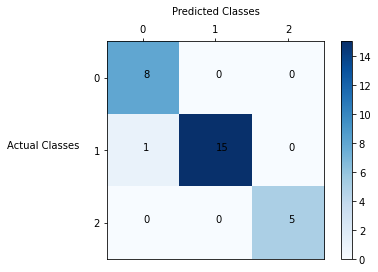

Accuracy Score on Outer Loop Data :  0.9655172413793104
Recall Score on Outer Loop : Class 0 = 1.000, Class 1 = 0.938, Class 2 = 1.000
Precision Score on Outer Loop: Class 0 = 0.889, Class 1 = 1.000, Class 2 = 1.000


============ Fold 2 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.897')
('manhattan', 1, '0.862')
('euclidean', 2, '0.966')
('manhattan', 2, '0.966')
('euclidean', 3, '0.931')
('manhattan', 3, '0.931')
('euclidean', 4, '0.931')
('manhattan', 4, '0.862')
('euclidean', 5, '0.931')
('manhattan', 5, '0.931')
('euclidean', 6, '0.931')
('manhattan', 6, '0.931')
('euclidean', 7, '0.931')
('manhattan', 7, '0.931')
('euclidean', 8, '0.931')
('manhattan', 8, '0.931')
('euclidean', 9, '0.931')
('manhattan', 9, '0.931')
('euclidean', 10, '0.931')
('manhattan', 10, '0.931')


Most Accurate Parameters:  Distance = euclidean , K = 2 



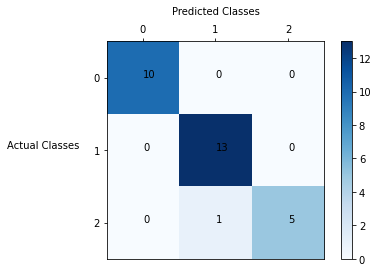

Accuracy Score on Outer Loop Data :  0.9655172413793104
Recall Score on Outer Loop : Class 0 = 1.000, Class 1 = 1.000, Class 2 = 0.833
Precision Score on Outer Loop: Class 0 = 1.000, Class 1 = 0.929, Class 2 = 1.000


============ Fold 3 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.931')
('manhattan', 1, '0.897')
('euclidean', 2, '0.931')
('manhattan', 2, '0.931')
('euclidean', 3, '0.966')
('manhattan', 3, '0.931')
('euclidean', 4, '0.897')
('manhattan', 4, '0.931')
('euclidean', 5, '0.931')
('manhattan', 5, '0.931')
('euclidean', 6, '0.931')
('manhattan', 6, '0.931')
('euclidean', 7, '0.931')
('manhattan', 7, '0.931')
('euclidean', 8, '0.931')
('manhattan', 8, '0.931')
('euclidean', 9, '0.931')
('manhattan', 9, '0.931')
('euclidean', 10, '0.931')
('manhattan', 10, '0.931')


Most Accurate Parameters:  Distance = euclidean , K = 3 



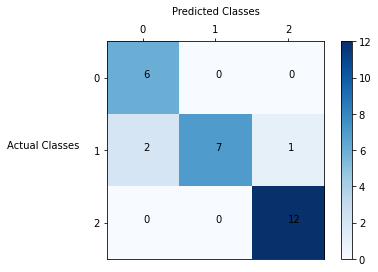

Accuracy Score on Outer Loop Data :  0.8928571428571429
Recall Score on Outer Loop : Class 0 = 1.000, Class 1 = 0.700, Class 2 = 1.000
Precision Score on Outer Loop: Class 0 = 0.750, Class 1 = 1.000, Class 2 = 0.923


============ Fold 4 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.862')
('manhattan', 1, '0.862')
('euclidean', 2, '0.966')
('manhattan', 2, '0.966')
('euclidean', 3, '0.931')
('manhattan', 3, '0.897')
('euclidean', 4, '0.931')
('manhattan', 4, '0.966')
('euclidean', 5, '0.931')
('manhattan', 5, '0.897')
('euclidean', 6, '0.897')
('manhattan', 6, '0.966')
('euclidean', 7, '0.931')
('manhattan', 7, '0.931')
('euclidean', 8, '0.966')
('manhattan', 8, '0.897')
('euclidean', 9, '0.931')
('manhattan', 9, '0.897')
('euclidean', 10, '0.931')
('manhattan', 10, '0.966')


Most Accurate Parameters:  Distance = euclidean , K = 2 



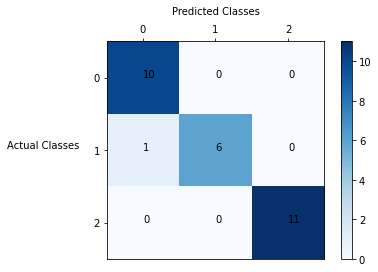

Accuracy Score on Outer Loop Data :  0.9642857142857143
Recall Score on Outer Loop : Class 0 = 1.000, Class 1 = 0.857, Class 2 = 1.000
Precision Score on Outer Loop: Class 0 = 0.909, Class 1 = 1.000, Class 2 = 1.000


============ Fold 5 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.862')
('manhattan', 1, '0.931')
('euclidean', 2, '0.966')
('manhattan', 2, '0.862')
('euclidean', 3, '0.931')
('manhattan', 3, '0.931')
('euclidean', 4, '0.897')
('manhattan', 4, '0.897')
('euclidean', 5, '0.931')
('manhattan', 5, '0.931')
('euclidean', 6, '0.931')
('manhattan', 6, '0.931')
('euclidean', 7, '0.931')
('manhattan', 7, '0.931')
('euclidean', 8, '0.931')
('manhattan', 8, '0.931')
('euclidean', 9, '0.931')
('manhattan', 9, '0.931')
('euclidean', 10, '0.931')
('manhattan', 10, '0.931')


Most Accurate Parameters:  Distance = euclidean , K = 2 



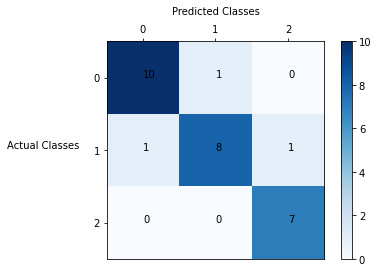

Accuracy Score on Outer Loop Data :  0.8928571428571429
Recall Score on Outer Loop : Class 0 = 0.909, Class 1 = 0.800, Class 2 = 1.000
Precision Score on Outer Loop: Class 0 = 0.909, Class 1 = 0.889, Class 2 = 0.875


============ All Folds============== 

Mean accuracy is 0.936 and stdev is 0.035


[0.9655172413793104,
 0.9655172413793104,
 0.8928571428571429,
 0.9642857142857143,
 0.8928571428571429]

In [34]:
# evaluate clean data code
my_nested_cross_val(X_train,y_train,5,(list(range(1,11))),['euclidean','manhattan'], 3)


### Noisy Data

============ Fold 1 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.917')
('manhattan', 1, '0.889')
('euclidean', 2, '0.917')
('manhattan', 2, '0.944')
('euclidean', 3, '0.944')
('manhattan', 3, '0.944')
('euclidean', 4, '0.917')
('manhattan', 4, '0.972')
('euclidean', 5, '0.972')
('manhattan', 5, '0.944')
('euclidean', 6, '0.972')
('manhattan', 6, '0.972')
('euclidean', 7, '0.972')
('manhattan', 7, '0.944')
('euclidean', 8, '0.944')
('manhattan', 8, '0.944')
('euclidean', 9, '0.972')
('manhattan', 9, '0.972')
('euclidean', 10, '0.917')
('manhattan', 10, '0.972')


Most Accurate Parameters:  Distance = manhattan , K = 4 



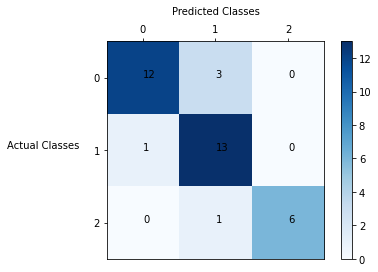

Accuracy Score on Outer Loop Data :  0.8611111111111112
Recall Score on Outer Loop : Class 0 = 0.800, Class 1 = 0.929, Class 2 = 0.857
Precision Score on Outer Loop: Class 0 = 0.923, Class 1 = 0.765, Class 2 = 1.000


============ Fold 2 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.833')
('manhattan', 1, '0.833')
('euclidean', 2, '0.861')
('manhattan', 2, '0.917')
('euclidean', 3, '0.889')
('manhattan', 3, '0.889')
('euclidean', 4, '0.889')
('manhattan', 4, '0.861')
('euclidean', 5, '0.861')
('manhattan', 5, '0.917')
('euclidean', 6, '0.889')
('manhattan', 6, '0.889')
('euclidean', 7, '0.889')
('manhattan', 7, '0.917')
('euclidean', 8, '0.889')
('manhattan', 8, '0.889')
('euclidean', 9, '0.889')
('manhattan', 9, '0.917')
('euclidean', 10, '0.861')
('manhattan', 10, '0.889')


Most Accurate Parameters:  Distance = manhattan , K = 2 



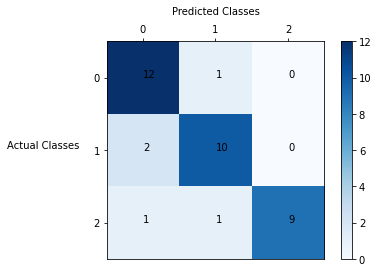

Accuracy Score on Outer Loop Data :  0.8611111111111112
Recall Score on Outer Loop : Class 0 = 0.923, Class 1 = 0.833, Class 2 = 0.818
Precision Score on Outer Loop: Class 0 = 0.800, Class 1 = 0.833, Class 2 = 1.000


============ Fold 3 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.833')
('manhattan', 1, '0.833')
('euclidean', 2, '0.833')
('manhattan', 2, '0.806')
('euclidean', 3, '0.861')
('manhattan', 3, '0.861')
('euclidean', 4, '0.861')
('manhattan', 4, '0.889')
('euclidean', 5, '0.861')
('manhattan', 5, '0.889')
('euclidean', 6, '0.861')
('manhattan', 6, '0.917')
('euclidean', 7, '0.889')
('manhattan', 7, '0.917')
('euclidean', 8, '0.833')
('manhattan', 8, '0.861')
('euclidean', 9, '0.833')
('manhattan', 9, '0.861')
('euclidean', 10, '0.861')
('manhattan', 10, '0.861')


Most Accurate Parameters:  Distance = manhattan , K = 6 



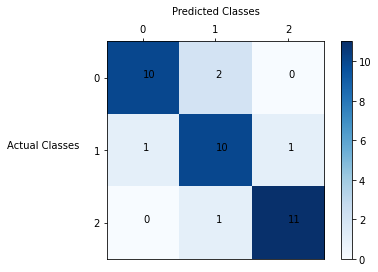

Accuracy Score on Outer Loop Data :  0.8611111111111112
Recall Score on Outer Loop : Class 0 = 0.833, Class 1 = 0.833, Class 2 = 0.917
Precision Score on Outer Loop: Class 0 = 0.909, Class 1 = 0.769, Class 2 = 0.917


============ Fold 4 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.861')
('manhattan', 1, '0.889')
('euclidean', 2, '0.889')
('manhattan', 2, '0.917')
('euclidean', 3, '0.833')
('manhattan', 3, '0.889')
('euclidean', 4, '0.889')
('manhattan', 4, '0.889')
('euclidean', 5, '0.861')
('manhattan', 5, '0.889')
('euclidean', 6, '0.889')
('manhattan', 6, '0.917')
('euclidean', 7, '0.889')
('manhattan', 7, '0.917')
('euclidean', 8, '0.833')
('manhattan', 8, '0.861')
('euclidean', 9, '0.861')
('manhattan', 9, '0.861')
('euclidean', 10, '0.889')
('manhattan', 10, '0.917')


Most Accurate Parameters:  Distance = manhattan , K = 2 



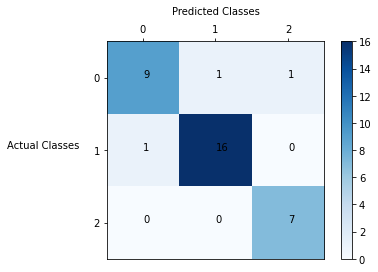

Accuracy Score on Outer Loop Data :  0.9142857142857143
Recall Score on Outer Loop : Class 0 = 0.818, Class 1 = 0.941, Class 2 = 1.000
Precision Score on Outer Loop: Class 0 = 0.900, Class 1 = 0.941, Class 2 = 0.875


============ Fold 5 ============== 

Accuracy Score for each Set of Parameters:


('euclidean', 1, '0.778')
('manhattan', 1, '0.861')
('euclidean', 2, '0.917')
('manhattan', 2, '0.833')
('euclidean', 3, '0.861')
('manhattan', 3, '0.861')
('euclidean', 4, '0.833')
('manhattan', 4, '0.861')
('euclidean', 5, '0.833')
('manhattan', 5, '0.861')
('euclidean', 6, '0.833')
('manhattan', 6, '0.917')
('euclidean', 7, '0.889')
('manhattan', 7, '0.917')
('euclidean', 8, '0.861')
('manhattan', 8, '0.861')
('euclidean', 9, '0.889')
('manhattan', 9, '0.917')
('euclidean', 10, '0.889')
('manhattan', 10, '0.944')


Most Accurate Parameters:  Distance = manhattan , K = 10 



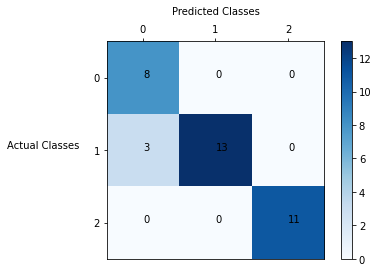

Accuracy Score on Outer Loop Data :  0.9142857142857143
Recall Score on Outer Loop : Class 0 = 1.000, Class 1 = 0.812, Class 2 = 1.000
Precision Score on Outer Loop: Class 0 = 0.727, Class 1 = 1.000, Class 2 = 1.000


============ All Folds============== 

Mean accuracy is 0.882 and stdev is 0.026


[0.8611111111111112,
 0.8611111111111112,
 0.8611111111111112,
 0.9142857142857143,
 0.9142857142857143]

In [35]:
# evaluate noisy  data code
my_nested_cross_val(XN,y,5,(list(range(1,11))),['euclidean','manhattan'], 3)

## 5. Summary of results

**Clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.889  |  3 | euclidean  |
| 2 | 0.972  |  3 | euclidean  |
| 3 | 0.944  |  4 | manhattan  |
| 4 | 0.971  |  5 | euclidean  |
| 5 | 0.914  |  2 | euclidean  |
| **total** | 0.938 $\pm$ 0.033 |   |    |

**Total** is given as an average over all the folds, and $\pm$ the standard deviation.

**Noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.861  |  4 | manhattan  |
| 2 | 0.861  |  2 | manhattan  |
| 3 | 0.861  |  6 | manhattan  |
| 4 | 0.914  |  2 | manhattan  |
| 5 | 0.914  |  10 | manhattan  |
| **total** | 0.882 $\pm$ 0.026 |   |    |


### Confusion matrix summary

I adapted my nested cross validation code to summarise the overall results of its evaluation of the algorithm using two summary confusion matrices (one for the noisy data, one for the clean data).


#### Adapted NCV code for Conf_Matrix

In [38]:
def my_ncv_matrix(features,target,folds,k_list, dis_measures, my_seed):
    """
    This function nested cross validation and 
    calculates the summary confusion matrix for all folds.
    
    The outer loop splits the data into the 
    specified number of `folds`. The inner loop splits the training data into 
    training and validations sets and evaluates the `dis_measure` and `k_list`.
    Then trains and test the parameters with the best accuracy on 
    the outer folds of data. 
    
    Parameters
    ----------
    features : numpy.ndarray 
        Array of selected features
    target : numpy.ndarray
        Array of the target classes
    folds : int
        Number of folds
    k_list : list
        List of k values
    dis_measures : list
        List of distance metrics 
    my_seed : int
        Random seed used to replicate results
    Returns
    -------
     confusion_matrix : list
        List of confusion matrices
                 
    """ 
    
    np.random.seed(my_seed)
    indices = np.random.permutation(np.arange(0,len(features),1))
    indices = np.array_split(indices, folds)
    
    accuracy_outer = [] #list to store accuracies for each fold 
    outer_test_pred = [] #list to store true and predicted values for each fold
    confusion_matrix = [] #list to confusion matrices for each fold
    
    for iFold in range(0,folds):  
    
        #Take one fold for testing 
        testFold = indices[iFold]
        
        remaining_folds = np.delete(range(0,folds), iFold)
        
        #Take the remaining folds as training
        outer_training_fold = np.hstack([indices[i] for i in remaining_folds])
        
    
        for j in range(0,1): #Inner loop begins
            
            #Take one fold from outer training data as validation
            inner_val = indices[remaining_folds[0]]
            
            #Take the rest of the data for training
            inner_train = np.hstack([indices[i] for i in remaining_folds[1:]])
            
        

            params_fold = [] #list used to store all validated parameters and their accuracies
            Fold_accuracies_inner = []
        
            for k in k_list: # evaluate k and distance measures, on inner training and validation 
                
                for d in dis_measures:
                    
                    y_pred = my_KNN(features[inner_train], features[inner_val], target[inner_train], d, k)
                    
                    params_fold.append((d,k,'{:.3f}'.format(accuracy(conf_matrix(target[inner_val], y_pred)))))
                                        
            
            # sort list so parameters with kighest accuracy are at the top
            params_fold.sort(key=lambda params_fold: params_fold[2], reverse=True)
            best_dist = params_fold[0][0]
            best_k = params_fold[0][1]
            
        #train and test best parameter for each fold on outer loop trianing and testing data    
        y_pred = my_KNN(features[outer_training_fold],features[testFold],target[outer_training_fold],best_dist,best_k)
        accuracy_outer.append(accuracy(conf_matrix(target[testFold], y_pred)))

        outer_test_pred.append((target[testFold], y_pred))
        
        confusion_matrix.append(conf_matrix(outer_test_pred[iFold][0],outer_test_pred[iFold][1]))
    
    #To find summary confusion matrix of all folds, need to add them all together  
    conf_matrix_summary = sum(confusion_matrix)
    
    #Evalaute confusion matrix, using accuracy, recall and precision 
    print('Accuracy = {:.3f}'.format(accuracy(conf_matrix_summary)))
    
    print('Recall : Class 0 = {:.3f}, Class 1 = {:.3f}, Class 2 = {:.3f}'.format(recall(conf_matrix_summary)[0],
                                                                                 recall(conf_matrix_summary)[1],
                                                                                 recall(conf_matrix_summary)[2]))
          
    print('Precision: Class 0 = {:.3f}, Class 1 = {:.3f}, Class 2 = {:.3f}'.format(precision(conf_matrix_summary)[0],
                                                                       precision(conf_matrix_summary)[1],
                                                                       precision(conf_matrix_summary)[2]))
    plot_conf_matrix(conf_matrix_summary)
    return
    

============================ CLEAN ============================ 

Accuracy = 0.937
Recall : Class 0 = 0.978, Class 1 = 0.875, Class 2 = 0.976
Precision: Class 0 = 0.898, Class 1 = 0.961, Class 2 = 0.952


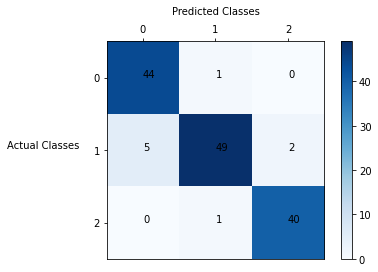

============================ NOISY ============================ 

Accuracy = 0.882
Recall : Class 0 = 0.864, Class 1 = 0.873, Class 2 = 0.917
Precision: Class 0 = 0.850, Class 1 = 0.861, Class 2 = 0.957


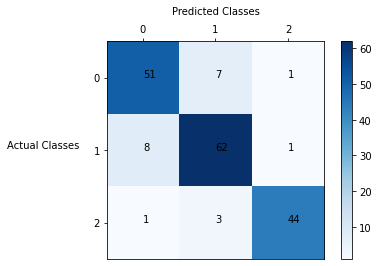

In [39]:
# clean data summary results
print('============================ CLEAN ============================', '\n')
my_ncv_matrix(X_train,y_train,5,(list(range(1,11))),['euclidean','manhattan'], 3)
plt.show()

# clean data summary results
print('============================ NOISY ============================', '\n')
my_ncv_matrix(XN,y,5,(list(range(1,11))),['euclidean','manhattan'], 3)


## Influence of noise


### Do the best parameters change when noise is added to the data? 
Comparatively when running the KNN using the manhattan distance with noisy data, it consistently achieved a higher accuracy. This may be due to the euclidean distance being more sensitive to noisy data, as the distance is computed by squaring the distance between the two vectors, so any variance will be magnified. Similarly the KNN was more accurate with noisy data when using a larger value of K, again if there is a noisy data point closest to the test sample, using a smaller K value could affect the accuracy of its classification more than a larger K value. 

### Is one parameter choice is better regardless of the data used? 
I believe the best parameter choice is subject to the characteristics of the data being used; the dimensionality, and the number of features can all have an effect on the accuracy of various distance measures. I feel the best way to identify the optimal parameters is through repeat training and testing by using techniques like cross validation methods and then examining the confusion matrices. 



## Changes to consider, if I used this with another dataset 

Currently my KNN doesn't standardise data, so I think I would need to add that in as an option, especially with datasets that have features on significantly different scales. I can use the function below as helper code or in my Nested cross validation as an optional parameter.

In [ ]:
def my_standard_scale(dataframe):
    """
    This function standardises every point in the dataframe. 
    
    Iterates through every column, and calucates the 
    mean and standard deviation for each column. 
    Formula applied to each point is [(point-mean)/stdev]
    
    Parameters
    ----------
    dataframe: pandas.core.frame.DataFrame
        Data to be standardised
    
    Returns
    -------
    features_norm
        New dataframe with standardised data 
    """
    
    lst = []
    for column in dataframe:
        x = np.array(dataframe[column].tolist())
        mean = np.mean(x)
        stdev = np.std(x)
    
        for i in x:
            lst.append(((i-mean)/stdev))
    
# iterating through the list and appending the number of observations for each column
#to a new list
    num_obsv = len(dataframe[dataframe.columns[0]])
    new_lst = []
    for i in range(int((len(lst)/num_obsv))):
        new_lst.append(lst[i*num_obsv:num_obsv+(i*num_obsv)]) 

#creating a new dataframe and popualting it with the observations 

    features_norm = pd.DataFrame()
    for i in range(len(dataframe.columns)):
        features_norm[dataframe.columns[i]] = new_lst[i]


    return features_norm

### Edited NCV function 

In [ ]:
def my_nested_cross_val_std(features,target,folds,k_list, dis_measures, my_seed, standardise):
    """
    This function uses a series of training, test and validation splits 
    to perform nested cross validation.
    
    The outer loop splits the data into the 
    specified number of `folds`. The inner loop splits the training data into 
    training and validations sets and evaluates the `dis_measure` and `k_list`.
    Then trains and test the parameters with the best accuracy on 
    the outer folds of data. 
    
    Parameters
    ----------
    features : numpy.ndarray 
        Array of selected features
    target : numpy.ndarray
        Array of the target classes
    folds : int
        Number of folds
    k_list : list
        List of k values
    dis_measures : list
        List of distance metrics 
    my_seed : int
        Random seed used to replicate results
    standardise : bool
        Standardise data, answer True or False
    Returns
    -------
    accuracies  : list  
        List of accuracies for each fold 
                 
    """ 
    if standardise == True:
        features = my_standard_scale(features).values
    
    #Creating random array of indices and then splitting into folds
    np.random.seed(my_seed)
    indices = np.random.permutation(np.arange(0,len(features),1))
    indices = np.array_split(indices, folds)
    
    accuracies = [] #list to store accuracies for each fold 
    outer_test_pred = [] #list to store true and predicted values for each fold
    
    for iFold in range(0,folds):  
    
        print('============ Fold %s ==============' % (iFold+1) , '\n')
    
        #Take one fold for testing 
        testFold = indices[iFold]
        
        remaining_folds = np.delete(range(0,folds), iFold)
        
        #Take the remaining folds as training
        outer_training_fold = np.hstack([indices[i] for i in remaining_folds])
    
    
        for j in range(0,1): #Inner loop begins, split every fold into validation and training
            
            #Take one fold from outer training data as validation
            inner_val = indices[remaining_folds[0]]
            
        
            #Take the rest of the data for training
            inner_train = np.hstack([indices[i] for i in remaining_folds[1:]])
            
        
            params_fold = [] #list used to store all validated parameters and their accuracies 
            Fold_accuracies_inner = []
            
            
            for k in k_list: # evaluate k and distance measures, on inner training and validation 
                
                for d in dis_measures:
                    
                    y_pred = my_KNN(features[inner_train], features[inner_val], target[inner_train], d, k)
                    
                    params_fold.append((d,k,'{:.3f}'.format(accuracy(conf_matrix(target[inner_val], y_pred)))))
                                        
            
            print('Accuracy Score for each Set of Parameters:','\n', *params_fold, sep = "\n", )
            # sort list so parameters with kighest accuracy are at the top
            params_fold.sort(key=lambda params_fold: params_fold[2], reverse=True)
            best_dist = params_fold[0][0]
            best_k = params_fold[0][1]
            print('\n') 
            print('Best Set of Parameters: ', 'Distance =', best_dist, ', K =', best_k, '\n')
    
        #train and test best parameter for each fold on outer loop trianing and testing data
        y_pred = my_KNN(features[outer_training_fold],features[testFold],target[outer_training_fold],best_dist,best_k)
        accuracies.append(accuracy(conf_matrix(target[testFold], y_pred)))
        print('Best Parameter Accuracy Score on Outer Loop Data : ', accuracies[iFold], '\n')
        
          

        
        outer_test_pred.append((target[testFold], y_pred))
        plot_conf_matrix(conf_matrix(outer_test_pred[iFold][0],outer_test_pred[iFold][1]))
        plt.show()
        
        print('\n') 
    print('============ All Folds==============', '\n')
    print('Mean accuracy is {:.3f} and stdev is {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))
    
    return accuracies
                                        